# Parameters:

In [17]:
symbol = "ETHUSDT"
askBidPriceDifference = 0.01
checkPointPriceStepRatio = 0.001
kLinesInterval = "1s"

# Environment:

In [18]:
!pip install pandas
!pip install matplotlib

import datetime as dt
import glob

import matplotlib.dates as dates
import matplotlib.pyplot as plot
import pandas as pd

You should consider upgrading via the '/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/.venv/bin/python -m pip install --upgrade pip' command.


# Input K-lines:

In [19]:
# https://www.binance.com/en/support/faq/how-to-download-historical-market-data-on-binance-5810ae42176b4770b880ce1f14932262

kLinesCsvFiles = glob.glob(f"../ttm-data/{symbol}-{kLinesInterval}-*.csv")
kLinesDataFrames = (
  pd.read_csv(kLinesCsvFile, sep=",", header=None,
              names=["openTimestampMillis", "openPrice", "highPrice", "lowPrice", "closePrice", "volume",
                     "closeTimestampMillis", "quoteAssetVolume", "tradesCount",
                     "takerBuyBaseAssetVolume", "takerBuyQuoteAssetVolume", "ignore"]
              ) for kLinesCsvFile in kLinesCsvFiles)

kLinesDataFrame = pd.concat(kLinesDataFrames).sort_values(by=['openTimestampMillis'])

kLinesDataFrame.head(10)

,openTimestampMillis,openPrice,highPrice,lowPrice,closePrice,volume,closeTimestampMillis,quoteAssetVolume,tradesCount,takerBuyBaseAssetVolume,takerBuyQuoteAssetVolume,ignore
0,1677628800000,1605.24,1605.47,1605.23,1605.47,7.9272,1677628800999,12725.338503,34,7.0694,11348.217718,0
1,1677628801000,1605.46,1605.46,1605.46,1605.46,0.4193,1677628801999,673.169378,5,0.0000,0.000000,0
2,1677628802000,1605.46,1605.47,1605.46,1605.46,1.8458,1677628802999,2963.359645,10,0.1577,253.182619,0
3,1677628803000,1605.46,1605.47,1605.46,1605.47,0.7839,1677628803999,1258.525272,13,0.5178,831.312366,0
4,1677628804000,1605.47,1605.47,1605.46,1605.46,0.1706,1677628804999,273.891924,2,0.0448,71.925056,0
5,1677628805000,1605.46,1605.47,1605.34,1605.34,46.2850,1677628805999,74307.934140,36,0.5470,878.167970,0
6,1677628806000,1605.35,1605.35,1605.35,1605.35,1.4372,1677628806999,2307.209020,9,1.4372,2307.209020,0
7,1677628807000,1605.34,1605.35,1605.25,1605.25,4.4919,1677628807999,7210.988771,12,0.0354,56.829390,0
8,1677628808000,1605.21,1605.21,1605.20,1605.20,3.3124,1677628808999,5317.065172,7,0.0692,111.080532,0
9,1677628809000,1605.21,1605.21,1605.08,1605.08,1.6745,1677628809999,2687.778008,12,0.8355,1341.063385,0


# Ticks:

In [20]:
kLines = kLinesDataFrame.iterrows()

ticks = []

for kLineIndex, kLine in kLines:
  kLineOpenTimestampMillis = kLine.openTimestampMillis
  kLineOpenPrice = kLine.openPrice

  tickTimestampMillis = kLineOpenTimestampMillis
  tickTimestampSeconds = int(tickTimestampMillis / 1000)
  tickPrice = kLineOpenPrice

  tick = {}
  tick["timestampSeconds"] = tickTimestampSeconds
  tick["bidPrice"] = tickPrice
  tick["askPrice"] = tickPrice + askBidPriceDifference

  ticks.append(tick)

ticksDataFrame = pd.DataFrame(ticks)

ticksDataFrame.head(10)

,timestampSeconds,bidPrice,askPrice
0,1677628800,1605.24,1605.25
1,1677628801,1605.46,1605.47
2,1677628802,1605.46,1605.47
3,1677628803,1605.46,1605.47
4,1677628804,1605.47,1605.48
5,1677628805,1605.46,1605.47
6,1677628806,1605.35,1605.36
7,1677628807,1605.34,1605.35
8,1677628808,1605.21,1605.22
9,1677628809,1605.21,1605.22


# Ticks price:

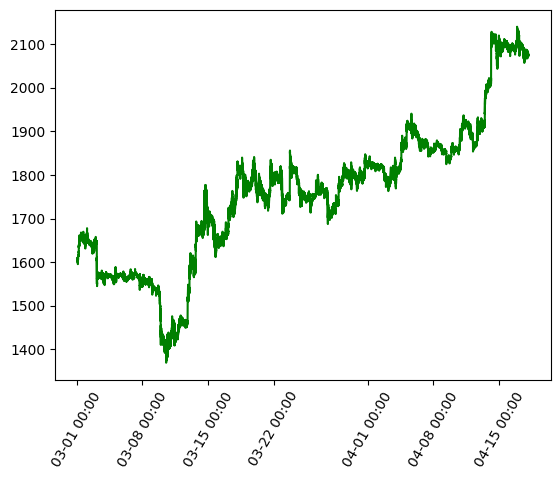

In [21]:
ticksPlotFigure = plot.figure()
ticksPlotAxes = ticksPlotFigure.add_subplot()
ticksPlotAxes.xaxis.set_major_formatter(dates.DateFormatter('%m-%d %H:%M'))
plot.xticks(rotation=60)

tickDateTimes = [dt.datetime.fromtimestamp(timestampSeconds) for timestampSeconds in ticksDataFrame.timestampSeconds]

ticksPlotAxes.plot(tickDateTimes, ticksDataFrame.bidPrice, color='green')


In [22]:
orders = []

checkPoint = None


def createCheckPoint(tick):
  checkPoint = {}
  checkPoint['tick'] = tick
  checkPoint['priceStep'] = tick['bidPrice'] * checkPointPriceStepRatio
  checkPoint['fallStepAskPrice'] = checkPoint["tick"]["bidPrice"] - checkPoint['priceStep']
  checkPoint['growStepBidPrice'] = checkPoint["tick"]["askPrice"] + checkPoint['priceStep']
  return checkPoint


def createOrder(tick, orderType):
  order = {}
  order['openTimestampSeconds'] = tick['timestampSeconds']
  order['openAskPrice'] = tick['askPrice']
  order['openBidPrice'] = tick['bidPrice']
  order['type'] = orderType
  # print(f"{orderType} order opened")
  return order


def closeOrder(order, tick):
  order['closeTimestampSeconds'] = tick['timestampSeconds']
  order['closeAskPrice'] = tick['askPrice']
  order['closeBidPrice'] = tick['bidPrice']
  if order['type'] == 'grow':
    order['profit'] = order['closeBidPrice'] - order['openAskPrice']
  elif order['type'] == 'fall':
    order['profit'] = order['openBidPrice'] - order['closeAskPrice']
    # print(f"Order closed with profit {order['profit']}")


currentOrder = None

for tick in ticks:
  if (checkPoint == None):
    checkPoint = createCheckPoint(tick)
    # print(f'Init check point: {checkPoint["tick"]["askPrice"]} / {checkPoint["tick"]["bidPrice"]} ({checkPoint["priceStep"]})')
    continue

  growStepDetected = tick['bidPrice'] >= checkPoint['growStepBidPrice']
  if (growStepDetected):
    # print(f"\nGrow step: {tick['bidPrice']} >= {checkPoint['growStepBidPrice']}")
    checkPoint = createCheckPoint(tick)
    # print(f'New check point: {checkPoint["tick"]["askPrice"]} / {checkPoint["tick"]["bidPrice"]} ({checkPoint["priceStep"]})')

  if (growStepDetected and currentOrder != None):
    closeOrder(currentOrder, tick)
    orders.append(currentOrder)
    currentOrder = None

  if (growStepDetected and currentOrder == None):
    currentOrder = createOrder(tick, 'fall')

  fallStepDetected = tick["askPrice"] <= checkPoint['fallStepAskPrice']
  if (fallStepDetected):
    # print(f"\nFall step: {tick['askPrice']} <= {checkPoint['fallStepAskPrice']}")
    checkPoint = createCheckPoint(tick)
    # print(f'New check point: {checkPoint["tick"]["askPrice"]} / {checkPoint["tick"]["bidPrice"]} ({checkPoint["priceStep"]})')

  if (fallStepDetected and currentOrder != None):
    closeOrder(currentOrder, tick)
    orders.append(currentOrder)
    currentOrder = None

  if (fallStepDetected and currentOrder == None):
    currentOrder = createOrder(tick, 'grow')


In [23]:
ordersDataFrame = pd.DataFrame(orders)

ordersDataFrame.head(10)

,openTimestampSeconds,openAskPrice,openBidPrice,type,closeTimestampSeconds,closeAskPrice,closeBidPrice,profit
0,1677629231,1603.36,1603.35,grow,1677629370,1601.49,1601.48,-1.88
1,1677629370,1601.49,1601.48,grow,1677629547,1603.29,1603.28,1.79
2,1677629547,1603.29,1603.28,fall,1677629568,1605.15,1605.14,-1.87
3,1677629568,1605.15,1605.14,fall,1677629857,1606.81,1606.80,-1.67
4,1677629857,1606.81,1606.80,fall,1677630140,1608.50,1608.49,-1.70
5,1677630140,1608.50,1608.49,fall,1677630526,1606.88,1606.87,1.61
6,1677630526,1606.88,1606.87,grow,1677630704,1608.50,1608.49,1.61
7,1677630704,1608.50,1608.49,fall,1677630739,1610.27,1610.26,-1.78
8,1677630739,1610.27,1610.26,fall,1677631405,1608.64,1608.63,1.62
9,1677631405,1608.64,1608.63,grow,1677631497,1607.02,1607.01,-1.63


In [24]:
profits = []

currentProfit = 0

for order in orders:
  profit = {}
  currentProfit = currentProfit + order['profit']
  profit['value'] = currentProfit
  profit['timestampSeconds'] = order['openTimestampSeconds']
  profits.append(profit)

profitsDataFrame = pd.DataFrame(profits)

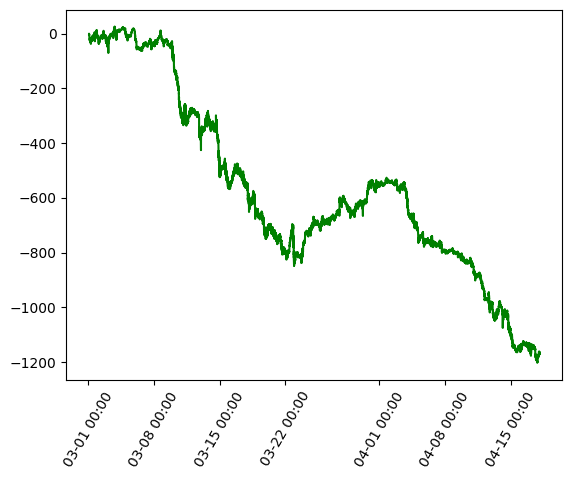

In [25]:
profitPlotFigure = plot.figure()
profitPlotAxes = profitPlotFigure.add_subplot()
profitPlotAxes.xaxis.set_major_formatter(dates.DateFormatter('%m-%d %H:%M'))
plot.xticks(rotation=60)

profitDateTimes = [dt.datetime.fromtimestamp(timestampSeconds) for timestampSeconds in
                   profitsDataFrame.timestampSeconds]

profitPlotAxes.plot(profitDateTimes, profitsDataFrame.value, color='green')

In [26]:
profits[len(profits) - 1]['value']

-1166.5800000001034

In [33]:
from lib.hello import plusTwo

plusTwo(5)


7